In [3]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr



from shapely.geometry import Point
import geopandas as gpd


#Custom modules
from lib import helper

#For the issue with .loc[]
pd.options.mode.chained_assignment = None





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
prediction_path = '/Users/gaurav/UAH/temperature_modelling/Resources/predictions/Madison_2021_/'
files = os.listdir(prediction_path)
files = sorted([os.path.join(prediction_path,x) for x in files if 'final' in x])

df1 = pd.read_csv(files[0])

for file in files[1:]:
    df2 = pd.read_csv(file)
    df1 = pd.concat([df1,df2])


In [32]:
df1

,prediction_temps,hour,latitude,longitude
0,23.965293,12,43.293393,-89.711999
1,24.569264,12,43.293393,-89.711999
2,27.713613,12,43.293393,-89.711999
3,30.254364,12,43.293393,-89.711999
4,30.965547,12,43.293393,-89.711999
...,...,...,...,...
191331,31.048342,12,43.015036,-89.405218
191332,29.607730,12,43.015036,-89.405218
191333,29.872291,12,43.015036,-89.405218
191334,31.077855,12,43.015036,-89.405218


In [60]:
full_prediction_df = df1.groupby(['latitude','longitude']).mean().reset_index()

segmented_df = full_prediction_df
segmented_df = helper.convert_to_gpd(segmented_df,'epsg:4326',convert_to='epsg:6879')
segmented_df.loc[segmented_df.prediction_temps < -10,'prediction_temps'] = np.nan

In [61]:
shapefile_path = '/Users/gaurav/UAH/ECOSTRESS_and_urban_surface_dataset/Madison/shpfile/Madison_WI_UA_mer.shp'
boundary_gdf = gpd.read_file(shapefile_path)
target_crs = boundary_gdf.crs

boundary_gdf_eps = boundary_gdf.to_crs(epsg=6879)

path_ = '/Users/gaurav/UAH/ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/geotiff_clipped_stateplane/ECO2LSTE.001_SDS_LST_doy2022167193705_aid0001_clipped_stateplane.tif'

temperature_data = rxr.open_rasterio(path_)

def get_plot(df_,pixel_size=150,change_null = False):
# gdf = df.sample(400000)[['latitude','longitude','prediction_temps']]
    gdf = df_[['latitude','longitude','prediction_temps']]
    gdf['geometry'] = [Point(xy) for xy in zip(gdf['longitude'], gdf['latitude'])]
    gdf = gpd.GeoDataFrame(gdf,geometry=gdf['geometry'],crs=temperature_data.rio.crs)
    
    xmin, ymin, xmax, ymax = gdf.total_bounds
    rows = int((ymax - ymin) / pixel_size)
    cols = int((xmax - xmin) / pixel_size)

    # Create the raster
    temperature_raster = np.zeros((rows, cols), dtype='float32')

    # Assign temperature values to the raster cells
    for index, row in gdf.iterrows():
        
        col = int((row['longitude'] - xmin) / pixel_size)
        r = int((ymax - row['latitude']) / pixel_size)
        
        # Check if indices are within bounds
        if 0 <= r < rows and 0 <= col < cols:
            temperature_raster[r, col] = row['prediction_temps']


    # return temperature_raster  

    if change_null:
        temperature_raster[temperature_raster == 0] = np.nan

    plt.figure(figsize=(10,10))
    plt.imshow(temperature_raster, extent=(xmin, xmax, ymin, ymax), cmap='plasma', origin='upper')
    boundary_gdf_eps.boundary.plot(ax=plt.gca(), edgecolor='white', linewidth=1)

    # gdf.plot(ax=plt.gca(), color='red', markersize=1)
    plt.colorbar()
    plt.show()

    return temperature_raster

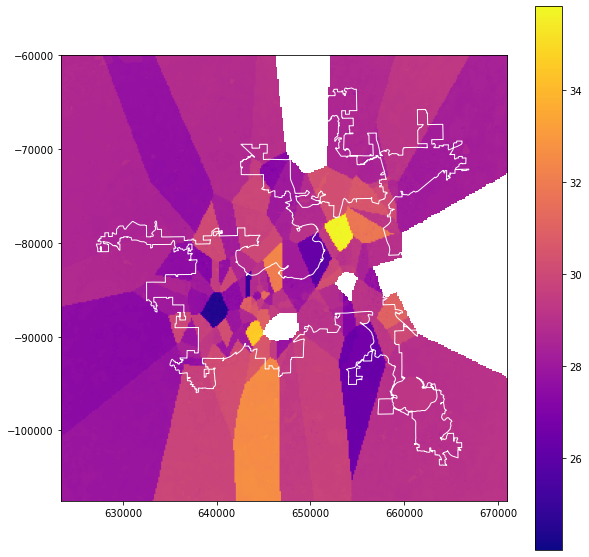

In [62]:
x = get_plot(segmented_df,pixel_size=150,change_null=True)

In [25]:
ec_data  = pd.read_csv('/Users/gaurav/UAH/temperature_modelling/data/raster_op/ECOSTRESS_values_testing.csv')
urb_data = pd.read_csv('/Users/gaurav/UAH/temperature_modelling/data/raster_op/urban_surface_properties_values_testing.csv')


## Model 1 : That uses only ecostress file for training

In [63]:
ec_data  = pd.read_csv('/Users/gaurav/UAH/temperature_modelling/data/raster_op/ECOSTRESS_values_testing.csv')
urb_data = pd.read_csv('/Users/gaurav/UAH/temperature_modelling/data/raster_op/urban_surface_properties_values_testing.csv')
urb_data['valueBuildingheight'] = urb_data['valueBuildingheight'].fillna(0)


In [64]:
ecostress_data = pd.read_csv('data/raster_op/ECOSTRESS_values.csv')
urban_data = pd.read_csv('data/raster_op/urban_surface_properties_values.csv')

In [221]:
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Point
# from rasterio.transform import from_origin
# import matplotlib.pyplot as plt

# path_ = '/Users/gaurav/UAH/ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/geotiff_clipped_stateplane/ECO2LSTE.001_SDS_LST_doy2022167193705_aid0001_clipped_stateplane.tif'

# temperature_data = rxr.open_rasterio(path_)

def get_plot(df_,boundary_gdf,pixel_size=150,change_null = False,cmap='plasma'):
# gdf = df.sample(400000)[['latitude','longitude','prediction_temps']]
    gdf = df_[['latitude','longitude','prediction_temps']]
    gdf['geometry'] = [Point(xy) for xy in zip(gdf['longitude'], gdf['latitude'])]
    gdf = gpd.GeoDataFrame(gdf,geometry=gdf['geometry'],crs=temperature_data.rio.crs)
    
    xmin, ymin, xmax, ymax = gdf.total_bounds
    rows = int((ymax - ymin) / pixel_size)
    cols = int((xmax - xmin) / pixel_size)

    # Create the raster
    temperature_raster = np.zeros((rows, cols), dtype='float32')

    # Assign temperature values to the raster cells
    for index, row in gdf.iterrows():
        col = int((row['longitude'] - xmin) / pixel_size)
        r = int((ymax - row['latitude']) / pixel_size)
        
        # Check if indices are within bounds
        if 0 <= r < rows and 0 <= col < cols:
            temperature_raster[r, col] = row['prediction_temps']

    if change_null:
        temperature_raster[temperature_raster == 0] = np.nan
    
    plt.figure(figsize=(10,10))
    plt.imshow(temperature_raster, extent=(xmin, xmax, ymin, ymax), cmap=cmap, origin='upper')
    boundary_gdf.boundary.plot(ax=plt.gca(), edgecolor='white', linewidth=1)

    # gdf.plot(ax=plt.gca(), color='red', markersize=1)
    plt.colorbar()
    plt.show()

    return temperature_raster

In [86]:
result_df = ecostress_data[['station','hour','value_LST']]
result_df = result_df.rename(columns={'value_LST':'adjusted_lst'})

clean_data = pd.read_csv('data/processed_data/Madison_2021/clean_Madison_pws_.csv')
clean_data['beg_time'] = pd.to_datetime(clean_data['beg_time'])
clean_data['hour'] = clean_data['beg_time'].dt.hour

clean_data = clean_data.query("day_of_year >= 30 & day_of_year <= 210")
updated_data = pd.merge(clean_data,result_df,on=['station','hour'],how='left')
updated_data = pd.merge(updated_data,urban_data,on=['station','latitude','longitude'],how='inner')

#removing unnecessary columns
updated_data = updated_data[['station', 'beg_time_x', 'latitude', 'longitude', 
        # 'humidityAvg',
       'temperature',
        # 'windspeed', 'dewpt', 'heatindex', 'precipRate',
       'day_of_year', 'hour', 'adjusted_lst', 'valueImperviousfraction', 'valueTreefraction',
       'valueBuildingheight', 'valueNearestDistWater', 'valueWaterfraction',
    #    'valueLandcover', 
       'valueBuildingfraction']]

updated_data.rename({'beg_time_x':'beg_time'},axis=1,inplace=True)
updated_data['valueBuildingheight'] = updated_data['valueBuildingheight'].fillna(0)


def split_(sequence, window_size):
    # sequence : input array of tempearture values : num_sample * 1
    # window_size : number of lagged values to be used as features

    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence.iloc[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)


def get_time_adjusted_df(final_df,start_end_date = [70,180],window_size=60,column='temperature'):
    window_size = window_size              #480 = 24 obs per day * 20 days : data from past 20 days is taken as features
    number_of_days = 720            #720 = 24 obs per day * 30 days : to predict for next 30 days
    start_date = start_end_date[0]
    end_date = start_end_date[1]

    final_df_slice = final_df.query(f'day_of_year > {start_date} and day_of_year < {end_date}')
    series = final_df_slice[column]

    X_train,y_train = split_(series, window_size)

    columns      = ['t_'+str(i) for i in range(window_size,0,-1)]
    final_df_    = final_df_slice[window_size:].reset_index(drop=True)
    temp_        = pd.DataFrame(X_train,columns=columns)
    time_adjusted_df = pd.concat([final_df_,temp_],axis=1)

    return time_adjusted_df


In [130]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

time_adjusted_df = get_time_adjusted_df(updated_data,start_end_date = [70,180],window_size=5,column='temperature')

time_adjusted_df.sort_values(['station','beg_time'],inplace=True)

# updated_data = updated_data[[ 'temperature','latitude', 'longitude',
#        'day_of_year', 'hour', 'adjusted_lst', 'valueImperviousfraction',
#        'valueTreefraction', 'valueBuildingheight', 'valueNearestDistWater',
#        'valueWaterfraction', 'valueBuildingfraction']]



In [139]:
y = time_adjusted_df['temperature']
X = time_adjusted_df.drop(['temperature','day_of_year'],axis=1)
X = X.iloc[:,2:-5]   


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=False)



In [142]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
print(mean_absolute_error(y_test,model.predict(X_test)))

7.6368369614492675


In [158]:
ec_data_12 = ec_data.query('hour == 12')
combined = ec_data_12.merge(urb_data,on=['station','latitude','longitude'],how='inner')
combined = combined.rename(columns={'value_LST':'adjusted_lst'})

combined = combined[['adjusted_lst', 'hour', 'latitude',
            'longitude', 'valueImperviousfraction',
       'valueTreefraction', 'valueBuildingheight', 'valueNearestDistWater',
       'valueWaterfraction', 'valueBuildingfraction']]

combined = helper.convert_to_gpd(combined,'epsg:6879',convert_to='epsg:4326')
combined = combined[X_train.columns]


,latitude,longitude,hour,adjusted_lst,valueImperviousfraction,valueTreefraction,valueBuildingheight,valueNearestDistWater,valueWaterfraction,valueBuildingfraction
0,43.293393,-89.711999,12,NaN,4.500000,35.000000,0.0,409.128319,0.0,6.18535
1,43.293390,-89.711137,12,NaN,9.750000,71.000000,0.0,461.445834,0.0,8.58991
2,43.293388,-89.710275,12,NaN,7.600000,48.000000,0.0,516.529580,0.0,9.47562
3,43.293386,-89.709412,12,NaN,7.333333,62.833333,0.0,574.868121,0.0,4.97263
4,43.293384,-89.708550,12,NaN,1.333333,54.000000,0.0,635.565816,0.0,4.70182
...,...,...,...,...,...,...,...,...,...,...
463756,42.862098,-89.135352,12,NaN,0.000000,0.000000,0.0,535.496209,0.0,0.00000
463757,42.862091,-89.134496,12,NaN,0.000000,0.000000,0.0,577.140090,0.0,0.00000
463758,42.862084,-89.133640,12,NaN,0.000000,0.000000,0.0,612.462819,0.0,0.00000
463759,42.862078,-89.132784,12,NaN,0.000000,0.000000,0.0,650.683398,0.0,0.00000


In [203]:
combinedx = combined.fillna(0)
combinedx['prediction'] = model.predict(combinedx)

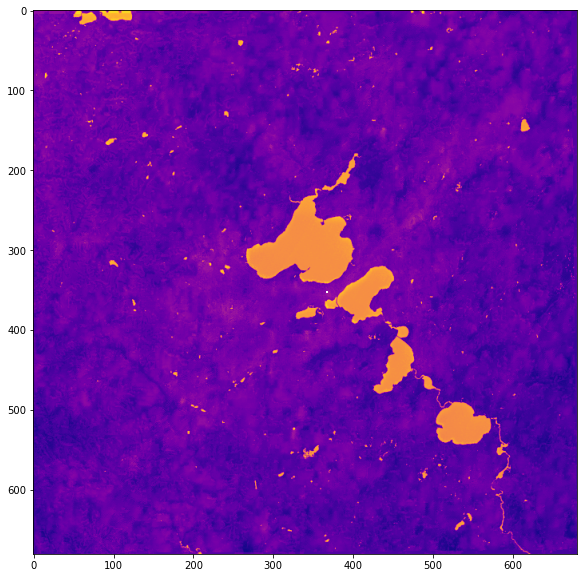

In [219]:
# plt.imshow(combinedx['prediction'].values.reshape(681,681))
# plt.imshow(combinedx[combinedx.prediction>0]['prediction'].values.reshape(681,681))
# combinedx[combinedx.prediction>0]['prediction'] = np.nan
# plt.imshow(combinedx['prediction'].values.reshape(681,681))

combinedx.loc[combinedx.prediction < -10,'prediction'] = np.nan
plt.figure(figsize=(10,10))
plt.imshow(combinedx['prediction'].values.reshape(681,681),cmap='plasma')





In [184]:
full_prediction_df = combinedx[['latitude','longitude','prediction']]
full_prediction_df = full_prediction_df.rename({'prediction':'prediction_temps'},axis=1)

#Selecting one hour for demo purpose
segmented_df = full_prediction_df
segmented_df = helper.convert_to_gpd(segmented_df,'epsg:4326',convert_to='epsg:6879')

segmented_df.loc[segmented_df.prediction_temps > 60,'prediction_temps'] = np.nan


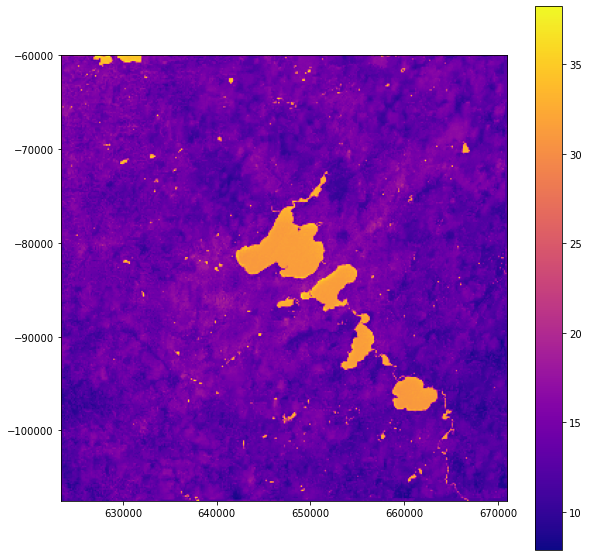

array([[17.683258 , 17.416344 , 17.72116  , ..., 12.091142 , 12.094642 ,
        12.180295 ],
       [17.060331 , 17.066929 , 17.689413 , ..., 12.080499 , 12.087003 ,
        12.244482 ],
       [14.951424 , 15.14235  , 15.859305 , ..., 12.12786  , 13.804236 ,
        12.272537 ],
       ...,
       [10.6630535, 11.705813 , 13.404774 , ..., 11.859659 , 11.414422 ,
        11.557647 ],
       [10.326772 , 11.383703 , 12.744662 , ..., 11.547428 , 11.464415 ,
        11.41565  ],
       [10.204955 , 10.430939 , 12.084841 , ..., 11.46101  , 11.381565 ,
        11.190549 ]], dtype=float32)

In [185]:
get_plot(segmented_df,pixel_size=150,change_null=True)

In [189]:
shapefile_path = '/Users/gaurav/UAH/ECOSTRESS_and_urban_surface_dataset/Madison/shpfile/Madison_WI_UA_mer.shp'
boundary_gdf = gpd.read_file(shapefile_path)
target_crs = boundary_gdf.crs

boundary_gdf_eps = boundary_gdf.to_crs(segmented_df.crs)

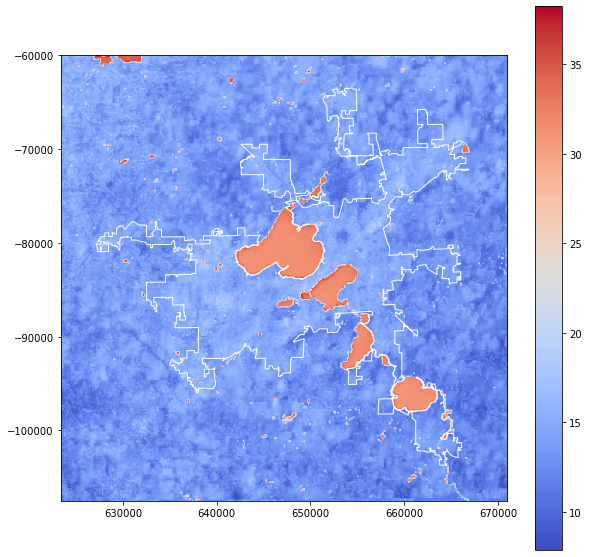

array([[17.683258 , 17.416344 , 17.72116  , ..., 12.091142 , 12.094642 ,
        12.180295 ],
       [17.060331 , 17.066929 , 17.689413 , ..., 12.080499 , 12.087003 ,
        12.244482 ],
       [14.951424 , 15.14235  , 15.859305 , ..., 12.12786  , 13.804236 ,
        12.272537 ],
       ...,
       [10.6630535, 11.705813 , 13.404774 , ..., 11.859659 , 11.414422 ,
        11.557647 ],
       [10.326772 , 11.383703 , 12.744662 , ..., 11.547428 , 11.464415 ,
        11.41565  ],
       [10.204955 , 10.430939 , 12.084841 , ..., 11.46101  , 11.381565 ,
        11.190549 ]], dtype=float32)

In [238]:
get_plot(segmented_df,boundary_gdf_eps, pixel_size=150,change_null=True,cmap='coolwarm')

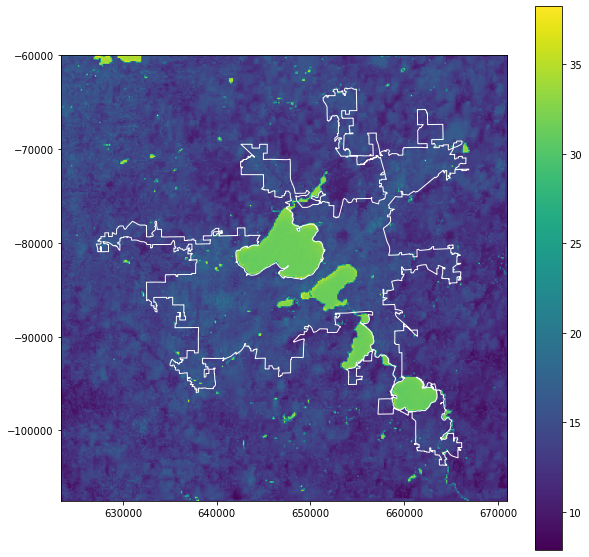

array([[17.683258 , 17.416344 , 17.72116  , ..., 12.091142 , 12.094642 ,
        12.180295 ],
       [17.060331 , 17.066929 , 17.689413 , ..., 12.080499 , 12.087003 ,
        12.244482 ],
       [14.951424 , 15.14235  , 15.859305 , ..., 12.12786  , 13.804236 ,
        12.272537 ],
       ...,
       [10.6630535, 11.705813 , 13.404774 , ..., 11.859659 , 11.414422 ,
        11.557647 ],
       [10.326772 , 11.383703 , 12.744662 , ..., 11.547428 , 11.464415 ,
        11.41565  ],
       [10.204955 , 10.430939 , 12.084841 , ..., 11.46101  , 11.381565 ,
        11.190549 ]], dtype=float32)

In [241]:
get_plot(segmented_df,boundary_gdf_eps, pixel_size=150,change_null=True,cmap='viridis')
